In [1]:
#| code-fold: true
import arviz as az
import pandas as pd
import numpy as np
import pymc3 as pm

from matplotlib import pylab as plt
from scipy import stats

from patsy import dmatrix

az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

## 4M1

For the model definition below, simulate observed $y$ values from the prior (not the posterior).

$$y \sim \text{Normal}(\mu, \sigma) $$
$$\mu \sim \text{Normal}(0, 10) $$
$$\sigma \sim \text{Exponential}(1) $$

In [ ]:
n_samples = 1000
sample_mu = stats.norm.rvs( loc=0, scale=10, size=n_samples )
sample_std = stats.expon.rvs( scale=1 , size=n_samples )
sample_y = stats.norm.rvs( loc=sample_mu, scale=sample_std, size=n_samples )

Text(0.5, 1.0, 'Distribution of Prior Predictive values')

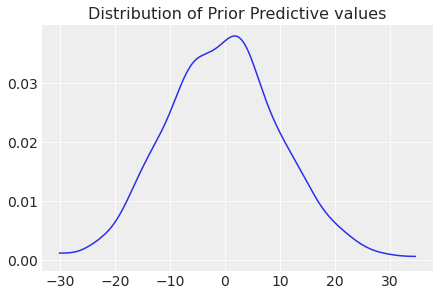

In [ ]:
az.plot_kde(sample_y)
plt.title('Distribution of Prior Predictive values')

(array([ 10.,  35., 116., 202., 232., 218., 118.,  47.,  17.,   5.]),
 array([-30.14262363, -23.65619686, -17.1697701 , -10.68334333,
         -4.19691657,   2.2895102 ,   8.77593697,  15.26236373,
         21.7487905 ,  28.23521727,  34.72164403]),
 <a list of 10 Patch objects>)

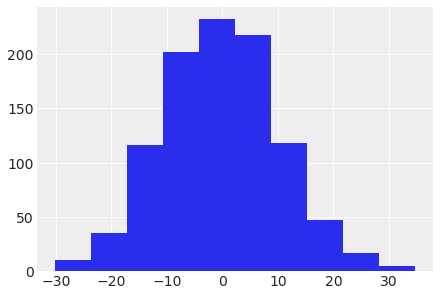

In [ ]:
plt.hist(sample_y)

(array([  8.,  26., 104., 183., 223., 217., 153.,  60.,  20.,   6.]),
 array([ 70.12975273,  76.34650859,  82.56326444,  88.7800203 ,
         94.99677615, 101.21353201, 107.43028787, 113.64704372,
        119.86379958, 126.08055544, 132.29731129]),
 <a list of 10 Patch objects>)

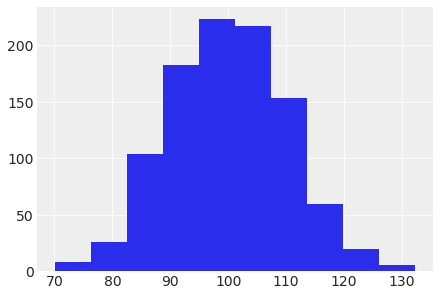

In [ ]:
#| include: false
plt.hist( stats.norm.rvs( loc=100, scale=10, size=n_samples ) ) 

## 4M4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

Let $h_{ij}$ be the height of the $i$-th student in year $j$ (where $j \in \{1,2,3\}$).  

$$h_{ij} \sim N(\mu_{ij},\sigma)$$
$$\mu_{ij} = \alpha + \beta(x_{ij}-\bar{x})$$
$$\alpha \sim N(100,10)$$
$$\beta \sim \text{Normal}(0,10)$$
$$\sigma \sim \text{Exponential}(1)$$

* Let $x_{ij}$ be the year corresponding to student $i$ for year $j$ in the dataset.
  * In particular, $x_{i1}=1, x_{i2}=2$ and $x_{i3}=3$. 
* Let $\bar{x}$ be the average year in the dataset. 
  * As each student was measured for height each year, $\bar{x} = \frac{1+2+3}{3}=2$.
* The mean height of the students is taking to be 100 cm.
* The Exponential is used as the prior distribution for $\sigma$ (the standard deviation) to constrain it to be positive.

Next, let's simulate a dataset consisting of 40 children:

In [ ]:
n_samples = 40
sample_alpha = stats.norm.rvs( loc=100, scale=10, size=n_samples )
sample_beta = stats.norm.rvs( loc=0, scale=10, size=n_samples )
sample_std = stats.expon.rvs( scale=1 , size=n_samples )

years = np.array([1,2,3])
xbar = np.mean( years )

# sample_y = stats.norm.rvs( loc=sample_mu, scale=sample_std, size=n_samples )

In [ ]:
#| include: false
sample_beta.shape

(40,)

In [ ]:
#| include: false
( sample_alpha.reshape(n_samples, 1) + 
 sample_beta.reshape(n_samples, 1) * (years - xbar).reshape(1, 3) ).shape

(40, 3)

In [ ]:
# Each row is a student, column 1 is for year-1, column 2 is for year-2 and
# column 3 is for year-3
sample_mu = ( sample_alpha.reshape(n_samples, 1) + 
             sample_beta.reshape(n_samples, 1) * (years - xbar).reshape(1, 3) )

In [ ]:
# Each row is a student, column 1 is for year-1, column 2 is for year-2 and
# column 3 is for year-3
sample_height = np.zeros((n_samples, 3))
for i in range(n_samples):
  for j in years:
    mu_ij = sample_alpha[i] + sample_beta[i]*(j - xbar)
    sample_height[i, j-1] = stats.norm.rvs( mu_ij , sample_std[i] )

Text(0, 0.5, 'height (cm)')

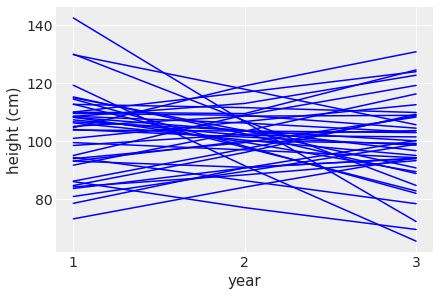

In [ ]:
for i in range(n_samples):
  plt.plot( years , sample_height[i] , color='blue' )
plt.xticks( years )
plt.xlabel( 'year' )
plt.ylabel( 'height (cm)' )

Each line tracks the simulated height of each student across the 3 years. Clearly there are some nonsensical relationships here where the height for some students actually goes down across the years.

## 4M5

Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

Yes, we can impose a Log-Normal prior on the slope so that it is constrained to be positive. Per {% cite wiki:Log-normal_distribution %}, if $Z \sim \text{Normal}(0,1)$ and if $\mu$ and $\sigma > 0$ are two real numbers then $\beta = e^{\mu + \sigma Z}$ is log-normally distributed with parameters $\mu$ and $\sigma$. Also $E[\beta] = e^{\mu + \frac{1}{2}\sigma^{2}}$.
  * So if $\mu=1$ and $\sigma=0.1$ then $E[\beta] \approx 2.73 \text{cm/year}$

In [ ]:
n_samples = 40
sample_alpha = stats.norm.rvs( loc=100, scale=10, size=n_samples )
sample_beta = np.random.lognormal( mean=1, sigma=0.1, size=n_samples)
sample_std = stats.expon.rvs( scale=1 , size=n_samples )

years = np.array([1,2,3])
xbar = np.mean( years )

sample_height = np.zeros((n_samples, 3))
for i in range(n_samples):
  for j in years:
    mu_ij = sample_alpha[i] + sample_beta[i]*(j - xbar)
    sample_height[i, j-1] = stats.norm.rvs( mu_ij , sample_std[i] )

Text(0, 0.5, 'height (cm)')

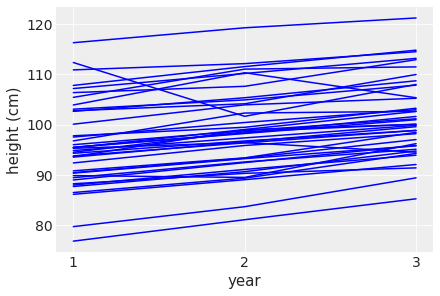

In [ ]:
for i in range(n_samples):
  plt.plot( years , sample_height[i] , color='blue' )
plt.xticks( years )
plt.xlabel( 'year' )
plt.ylabel( 'height (cm)' )

This looks much better with height increasing across the years. However there are still some weird observations where the height zig-zags.

## 4M6

Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

This would lead me to set $\sigma \sim \text{Uniform}(0,\sqrt{64})$

## 4M7

Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the new model’s posterior to that of the original model. In particular, look at the covariance among the parameters. What is different? Then compare the posterior predictions of both models.

In [2]:
#| echo: false
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', sep=';', header=0)
d2 = d[ d.age >= 18 ]
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000, return_inferencedata=False)

with pm.Model() as m4M7:
  alpha = pm.Normal( 'alpha', mu=178, sd=20 )
  beta = pm.Lognormal( 'beta', mu=0, sd=1 )
  sigma = pm.Uniform( 'sigma' , lower=0, upper=50 )
  mu = alpha + beta*d2.weight
  height = pm.Normal( 'height' , mu=mu, sd=sigma, observed=d2.height )
  trace_4M7 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8897350788344733, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
az.summary(trace_4M7, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,114.491,1.858,111.612,117.473
beta,0.892,0.041,0.826,0.955
sigma,5.093,0.202,4.750,5.383


In [ ]:
az.summary(trace_4_3, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
a,154.604,0.281,154.128,155.004
b,0.903,0.043,0.839,0.975
sigma,5.104,0.202,4.774,5.416


Model 4_3 intercept (a) is larger than in M47 (alpha) but the slope is roughly the same. 

### Plot the posterior inference against the data

#### Superimpose the posterior mean values over the height and weight data

Text(0, 0.5, 'height')

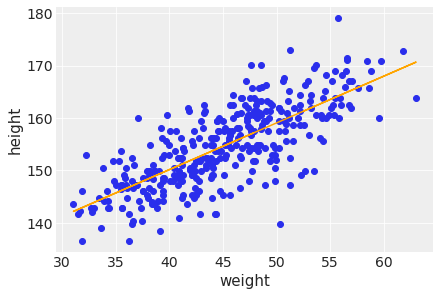

In [ ]:
plt.scatter(d2['weight'], d2['height'])
plt.plot(d2['weight'], ( trace_4M7['alpha'].mean() + 
                        trace_4M7['beta'].mean()*d2['weight'] ),
         color='orange' )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0])

#### Add the uncertainty around the mean

First add the uncertainty around the average height.

In [ ]:
trace_iq = trace_4M7 #trace in question
posterior_samples = np.random.randint(len(trace_iq), size=10000)
weight_seq = np.arange(0, 71)

In [ ]:
cred_intervals = np.array(
    [ az.hdi( trace_iq['alpha'][posterior_samples] + 
             trace_iq['beta'][posterior_samples]*wt ) for wt in weight_seq ]
)

In [ ]:
cred_intervals.shape

(71, 2)

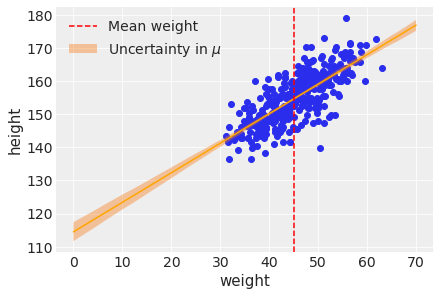

In [ ]:
plt.scatter(d2['weight'], d2['height'])
plt.plot(weight_seq, ( trace_4M7['alpha'].mean() + 
                        trace_4M7['beta'].mean()*weight_seq ),
         color='orange' )
plt.fill_between(
    weight_seq, cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.4, 
    label=r"Uncertainty in $\mu$",
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0])
plt.axvline(np.mean(d2.weight), ls="--", c="r", label="Mean weight")
plt.legend()

### Add the prediction intervals

Next add the uncertainty around the actual heights making use of the standard deviation.

In [ ]:
trace_iq['alpha'][posterior_samples].shape

(10000,)

In [ ]:
# define a function to compute mu for all posterior samples at given value of 
# weight
def compute_mu(w):
    return ( trace_iq['alpha'][posterior_samples] + 
            trace_iq['beta'][posterior_samples] * w )

pi_67 = np.array(
    [
        az.hdi(np.random.normal(loc=compute_mu(x), 
                                scale=trace_iq['sigma'][posterior_samples]), 
                                hdi_prob=0.67)
        for x in weight_seq
    ]
)

pi_89 = np.array(
    [
        az.hdi(np.random.normal(loc=compute_mu(x), 
                                scale=trace_iq['sigma'][posterior_samples]))
        for x in weight_seq
    ]
)

pi_97 = np.array(
    [
        az.hdi(np.random.normal(loc=compute_mu(x), 
                                scale=trace_iq['sigma'][posterior_samples]), 
                                hdi_prob=0.97)
        for x in weight_seq
    ]
)

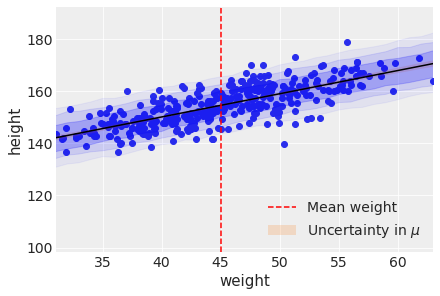

In [ ]:
plt.scatter(d2['weight'], d2['height'])
plt.plot(weight_seq, ( trace_4M7['alpha'].mean() + 
                        trace_4M7['beta'].mean()*weight_seq ),
         color='black' )
plt.fill_between(
    weight_seq, cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.2, 
    label=r"Uncertainty in $\mu$",
)
plt.fill_between(
    weight_seq, pi_67[:, 0], pi_67[:, 1], 
    alpha=0.2, color='blue' 
)
plt.fill_between(
    weight_seq, pi_89[:, 0], pi_89[:, 1], 
    alpha=0.1, color='blue' 
)
plt.fill_between(
    weight_seq, pi_97[:, 0], pi_97[:, 1], 
    alpha=0.05, color='blue' 
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0])
plt.axvline(np.mean(d2.weight), ls="--", c="r", label="Mean weight")
plt.xlim(d2.weight.min(), d2.weight.max());
plt.legend()

Another way to generate the same plot.

In [ ]:
# Given that we have 2,000 samples let's use 200 for plotting 
# (or we can use all of them too if desired)
trace_iq_thinned = trace_iq[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_iq_thinned) * trace_iq.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = ( trace_iq_thinned["alpha"] + 
                  trace_iq_thinned["beta"] * w )

In [ ]:
trace_iq_thinned, mu_pred.shape

(<MultiTrace: 2 chains, 100 iterations, 5 variables>, (71, 200))

In [ ]:
mu_mean = mu_pred.mean(1) 
mu_hdi = az.hdi(mu_pred.T)
mu_mean.shape, mu_hdi.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


((71,), (71, 2))

Generate heights from the posterior manually.

In [ ]:
post_samples = []
for _ in range(10000):  # number of samples from the posterior
    i = np.random.randint(len(trace_iq))
    mu_pr = trace_iq['alpha'][i] + trace_iq['beta'][i] * weight_seq
    sigma_pred = trace_iq['sigma'][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdip

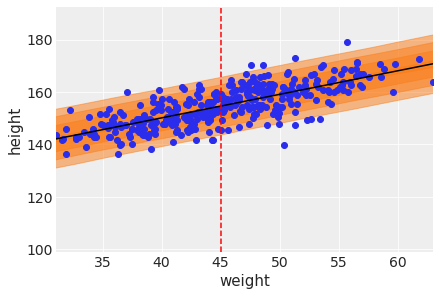

In [ ]:
ax=az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax, hdi_prob=0.67)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax, hdi_prob=0.89)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax, hdi_prob=0.97)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.axvline(np.mean(d2.weight), ls="--", c="r", label="Mean weight")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [ ]:
trace_4M7_df = pm.trace_to_dataframe( trace_4M7 )
trace_4M7_df.cov().round(3)

,alpha,beta,sigma
alpha,3.452,-0.076,-0.026
beta,-0.076,0.002,0.001
sigma,-0.026,0.001,0.041


There doesn't seem to be much of a covariance between the parameters. This is similar to what we saw in m_4_3 (shown below).

In [ ]:
pm.trace_to_dataframe( trace_4_3 ).cov().round(3)

,a,b,sigma
a,0.079,-0.000,-0.000
b,-0.000,0.002,0.000
sigma,-0.000,0.000,0.041


Next let's examine the correlations.

In [ ]:
trace_4M7_df.corr().round(3)

,alpha,beta,sigma
alpha,1.00,-0.99,-0.07
beta,-0.99,1.00,0.07
sigma,-0.07,0.07,1.00


Intercept (alpha) and slope (beta) are negatively correlated unlike model m_4_3.

In [ ]:
pm.trace_to_dataframe( trace_4_3 ).corr().round(3)

,a,b,sigma
a,1.000,-0.041,-0.000
b,-0.041,1.000,0.051
sigma,-0.000,0.051,1.000


## 4M8

In the chapter, we used 15 knots with the cherry blossom spline. Increase the number of knots and observe what happens to the resulting spline. Then adjust also the width of the prior on the weights -- change the standard deviation of the prior and watch what happens. What do you think the combination of knot number and the prior on the weight controls?

Suppose $D_{i}$ be the date of year of the cherry blossom in year $i$ then a formal description of the model is:  

$$D_{i} \sim N(\mu_{i},\sigma)$$
$$\mu_{i} = \alpha + \sum_{k=1}^{K}w_{k}B_{ki}$$
$$\alpha \sim N(100,10)$$
$$w_{k} \sim \text{Normal}(0,10)$$
$$\sigma \sim \text{Exponential}(1)$$

$B_{ki}$ is the value of the $k$-th basis function for year $i$.

In [3]:
url = 'https://raw.githubusercontent.com/rmcelreath/rethinking/'\
'master/data/cherry_blossoms.csv'
d = pd.read_csv(url, sep=';', header=0)
d.head()

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN


In [4]:
d2 = d.dropna(subset=['doy'])
d2.head()

,year,doy,temp,temp_upper,temp_lower
11,812,92.0,NaN,NaN,NaN
14,815,105.0,NaN,NaN,NaN
30,831,96.0,NaN,NaN,NaN
50,851,108.0,7.38,12.1,2.66
52,853,104.0,NaN,NaN,NaN


In [5]:
#| include: false
d2.describe()

,year,doy,temp,temp_upper,temp_lower
count,827.000000,827.000000,787.000000,787.000000,787.000000
mean,1548.841596,104.540508,6.100356,6.937560,5.263545
std,304.149774,6.407036,0.683410,0.811986,0.762194
min,812.000000,86.000000,4.690000,5.450000,2.610000
25%,1325.000000,100.000000,5.625000,6.380000,4.770000
50%,1583.000000,105.000000,6.060000,6.800000,5.250000
75%,1803.500000,109.000000,6.460000,7.375000,5.650000
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [68]:
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

In [69]:
#| code-fold: true
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

In [70]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

In [71]:
#| code-fold: true
np.asarray( B ).shape

(827, 17)

In [72]:
#| code-fold: true
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

In [73]:
#| include: false
B.base.shape

(827, 17)

In [74]:
#| include: false
np.where( B[:,0] > 0 )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),)

In [75]:
#| include: false
np.where( B[:,16] > 0 )

(array([768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
        781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
        794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806,
        807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819,
        820, 821, 822, 823, 824, 825, 826]),)

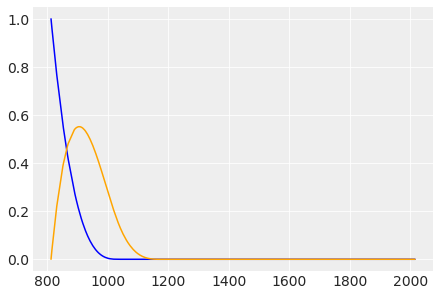

In [76]:
#| include: false
#how does the first basis function vary by year?
plt.plot(d2.year, (B[:, 0]), color='blue') 
#how does the second basis function vary by year?
plt.plot(d2.year, (B[:, 1]), color='orange')

Let's plot the basis functions.

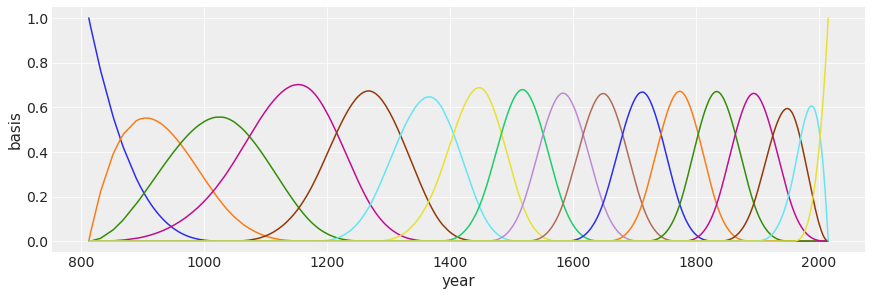

In [77]:
#| code-fold: true
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range( B.shape[1] ):
    ax.plot(d2.year, (B[:, i]))
ax.set_xlabel("year")
ax.set_ylabel("basis");

Next, let's learn the parameters.

In [78]:
with pm.Model() as m_4M8:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m_4M8 = pm.sample(2000, tune=2000, chains=2, 
                            return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [79]:
#| include: false
w

w ~ Normal

In [80]:
#| include: false
( trace_m_4M8['w'].mean(0) ).shape

(17,)

In [81]:
#| include: false
trace_m_4M8['w'].mean(0)[0]

-2.903071629814052

Plot each basis weighted by it's corresponding parameter.

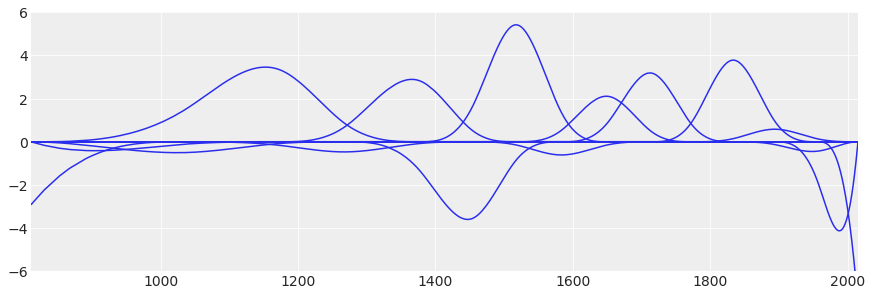

In [82]:
#| code-fold: true
_, ax = plt.subplots(1, 1, figsize=(12, 4))
wp = trace_m_4M8['w'].mean(0) #17 entries, one for each basis fn
for i in range( B.shape[1] ):
    ax.plot(d2.year, (wp[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

In [83]:
#| include: false
ap = ( az.summary(trace_m_4M8, var_names=['a'], hdi_prob=0.94).
             reset_index(drop=True) )
ap

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,103.223,2.443,98.736,107.781,0.112,0.079,479.0,1018.0,1.0


In [84]:
post_pred = ( az.summary(trace_m_4M8, var_names=["mu"], hdi_prob=0.94).
             reset_index(drop=True) )
post_pred.head()

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,100.320,3.179,93.831,105.847,0.050,0.035,4039.0,3348.0,1.0
1,100.406,2.994,94.330,105.655,0.047,0.033,4124.0,3292.0,1.0
2,100.822,2.182,96.796,105.020,0.032,0.023,4692.0,3168.0,1.0
3,101.262,1.555,98.286,104.116,0.021,0.015,5426.0,3262.0,1.0
4,101.302,1.514,98.484,104.162,0.021,0.015,5442.0,3287.0,1.0


Text(0.5, 1.0, 'knots=15')

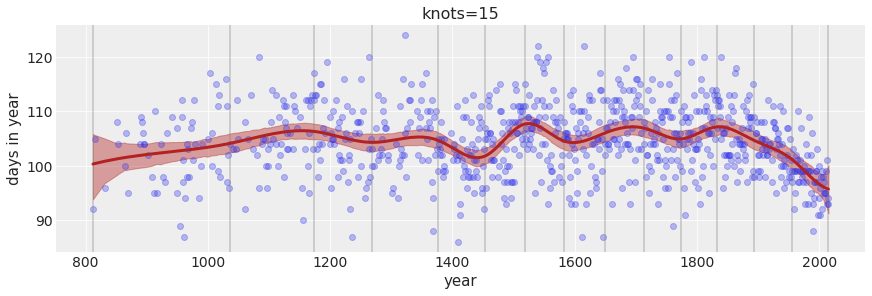

In [85]:
plt.fill_between(
    d2.year,
    post_pred["hdi_3%"],
    post_pred["hdi_97%"],
    color="firebrick",
    alpha=0.4,
);

ax = plt.gca()
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
for knot in knot_list:
    ax.axvline(knot, color="grey", alpha=0.4);
ax.plot(d2.year, 
        post_pred['mean'],
        lw=3, color="firebrick")

fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")
ax.set_title(f'knots={num_knots}')

Increase the number of knots to 30. 

In [86]:
#| include: false
num_knots = 30

knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

with pm.Model() as m_4M8:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m_4M8 = pm.sample(2000, tune=2000, chains=2, 
                            return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [87]:
#| include: false
post_pred = ( az.summary(trace_m_4M8, var_names=["mu"], hdi_prob=0.94).
             reset_index(drop=True) )

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(0.5, 1.0, 'knots=30')

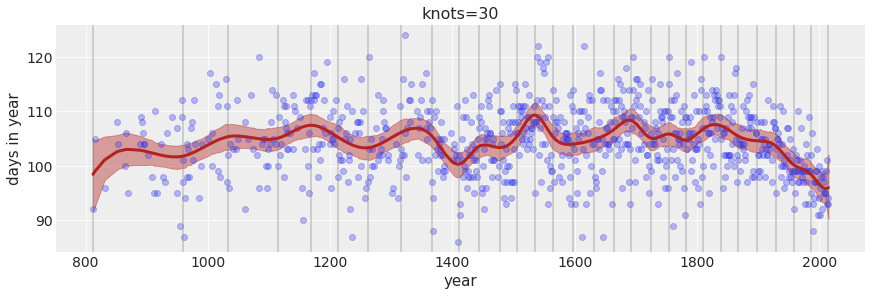

In [88]:
#| echo: false
plt.fill_between(
    d2.year,
    post_pred["hdi_3%"],
    post_pred["hdi_97%"],
    color="firebrick",
    alpha=0.4,
);

ax = plt.gca()
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
for knot in knot_list:
    ax.axvline(knot, color="grey", alpha=0.4);
ax.plot(d2.year, 
        post_pred['mean'],
        lw=3, color="firebrick")

fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")
ax.set_title(f'knots={num_knots}')

Change the width of the prior on the weights.

In [89]:
#| include: false
num_knots = 30
w_sd = 100

knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

with pm.Model() as m_4M8:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=w_sd, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m_4M8 = pm.sample(2000, tune=2000, chains=2, 
                            return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
There were 1911 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5641820922227876, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1919 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [90]:
#| include: false
post_pred = ( az.summary(trace_m_4M8, var_names=["mu"], hdi_prob=0.94).
             reset_index(drop=True) )

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(0.5, 1.0, 'knots=30; w ~ N(0,100)')

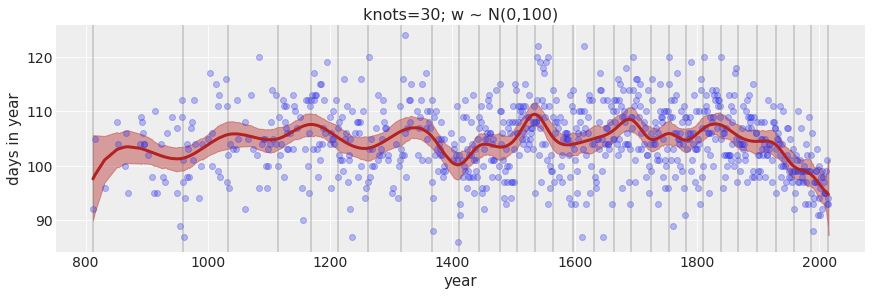

In [91]:
#| echo: false
plt.fill_between(
    d2.year,
    post_pred["hdi_3%"],
    post_pred["hdi_97%"],
    color="firebrick",
    alpha=0.4,
);

ax = plt.gca()
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
for knot in knot_list:
    ax.axvline(knot, color="grey", alpha=0.4);
ax.plot(d2.year, 
        post_pred['mean'],
        lw=3, color="firebrick")

fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")
ax.set_title(f'knots={num_knots}; w ~ N(0,{w_sd})')

In [92]:
#| include: false
num_knots = 30
w_sd = 1

knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

with pm.Model() as m_4M8:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=w_sd, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m_4M8 = pm.sample(2000, tune=2000, chains=2, 
                            return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


In [93]:
#| include: false
post_pred = ( az.summary(trace_m_4M8, var_names=["mu"], hdi_prob=0.94).
             reset_index(drop=True) )

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(0.5, 1.0, 'knots=30; w ~ N(0,1)')

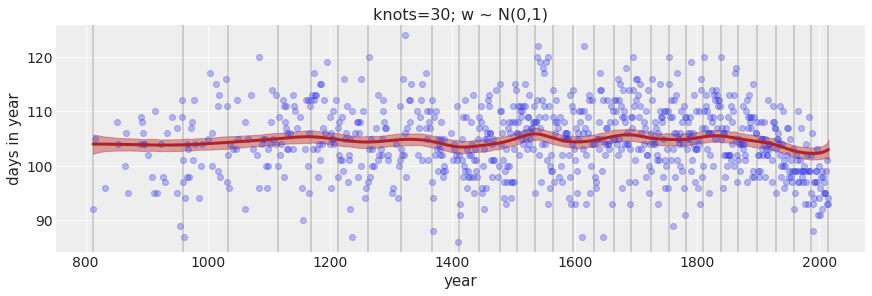

In [94]:
#| echo: false
plt.fill_between(
    d2.year,
    post_pred["hdi_3%"],
    post_pred["hdi_97%"],
    color="firebrick",
    alpha=0.4,
);

ax = plt.gca()
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
for knot in knot_list:
    ax.axvline(knot, color="grey", alpha=0.4);
ax.plot(d2.year, 
        post_pred['mean'],
        lw=3, color="firebrick")

fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")
ax.set_title(f'knots={num_knots}; w ~ N(0,{w_sd})')

In [95]:
#| include: false
num_knots = 5
w_sd = 100

knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

with pm.Model() as m_4M8:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=w_sd, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m_4M8 = pm.sample(2000, tune=2000, chains=2, 
                            return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [96]:
#| include: false
post_pred = ( az.summary(trace_m_4M8, var_names=["mu"], hdi_prob=0.94).
             reset_index(drop=True) )

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(0.5, 1.0, 'knots=5; w ~ N(0,100)')

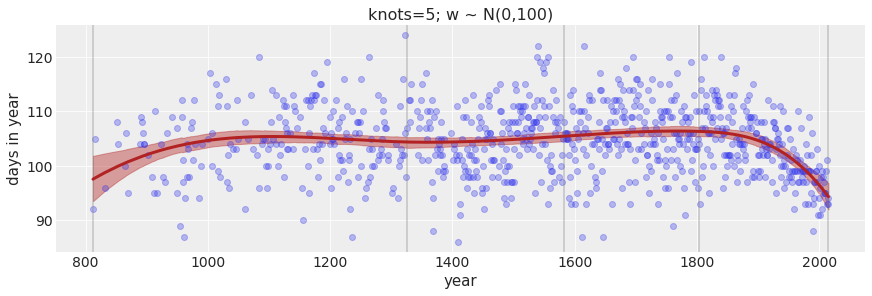

In [97]:
#| echo: false
plt.fill_between(
    d2.year,
    post_pred["hdi_3%"],
    post_pred["hdi_97%"],
    color="firebrick",
    alpha=0.4,
);

ax = plt.gca()
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
for knot in knot_list:
    ax.axvline(knot, color="grey", alpha=0.4);
ax.plot(d2.year, 
        post_pred['mean'],
        lw=3, color="firebrick")

fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")
ax.set_title(f'knots={num_knots}; w ~ N(0,{w_sd})')

The larger the number of knots the more local variation we are able to capture. The prior on the weight controls how much weights are allowed to vary around the mean. A tighter (smaller) standard deviation on the weight will not allow the weight to vary much.

References

{% bibliography --cited %}